In [91]:
import pyabf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from os import getcwd,listdir
import csv

# List all file

In [3]:
files = listdir("abf")
Files = []
for f in files:
    if f[:2] == '22':
        Files.append(f)
print(files)
print(Files)

['21930014.abf', '21d04000.abf', '21d04000.zip', '21n05000.abf', '21n05001.abf', '21n05002.abf', '21n05003.abf', '21n05004.abf', '21n05005.abf', '22214004.abf', '22214005.abf']
['22214004.abf', '22214005.abf']


# Stable

In [92]:
class Stable:
    def __init__(self,timeStart,timeEnd,pqty,flag,X,Y,current):
        self.timeStart = timeStart #開始判斷穩定區域的時間
        self.timeEnd = timeEnd #穩定區域結束的時間
        self.qty = timeEnd - timeStart #穩定區域大小
        self.pqty = pqty #采值取用點數數量
        self.close = flag #True: close; False: far
        self.Y = np.array(Y[timeStart:timeEnd]) #穩定區域的EMF值
        self.X = np.array(X[timeStart:timeEnd]) #穩定區域的秒數
        self.current = np.array(current[timeStart:timeEnd]) #穩定區域的current
        self.EMF = self.Y[-pqty:] #EMF計算區域
        self.I = self.current[-pqty:] #current 計算區域
        self.mEMF = np.mean(self.EMF)
        self.mI = np.mean(self.I)

# Function

## Version 1

In [93]:
def plot(timeStart = 0, timeEnd = None):
    plt.figure(figsize = (18,5))
    if timeEnd == None:
        plt.plot(abf.sweepX[timeStart:], abf.sweepY[timeStart:])
    else:
        plt.plot(abf.sweepX[timeStart:timeEnd], abf.sweepY[timeStart:timeEnd])
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.legend()
    plt.show()

In [94]:
def correction(Y,start,end,gap=0.1,p_flag = False):
    y = Y[start:end]
    y = y[::-1]
    extra = 0
    if p_flag:
        plt.figure()
        plt.plot(y)
        plt.show()
    for i in range(len(y)):
        mean = np.mean(Y[start:end-extra])
        if y[i]-y[i+1]<0.0:# or mean-y[i]>gap
            if p_flag:
                print("y[i]-y[i+1]: %lf - %lf = %lf"%(y[i],y[i+1],y[i]-y[i+1]))
                #print("mean-y[i]:%lf - %lf = %lf"%(mean,y[i],mean-y[i]))
            extra = extra + 1
        else:
            break
    if p_flag:
        plt.figure()
        plt.plot(y[extra:])
        plt.show()
        print("Extra = "+str(extra))
    return end-extra

In [95]:
def findStable(X,Y,countGap = 5,gap=0.3,errorGap = 5,mean_range=10,p_flag = False,threshold = 10,offset = 0):
    # Assume far and end come up one by one,start from far
    circleX=[]
    circleY=[]
    count = 0
    start = 0
    stable = []
    stable_close=[]
    stable_far=[]
    errorCount = 0
    close_flag = True
    
    # Find Stable: Algorithm
    for i in range(1,len(Y)):
        if abs(Y[i]-Y[i-1])<gap and Y[i]>threshold:
            count = count+1
            errorCount = 0
            if start == 0:
                start = i
        elif abs(Y[i]-Y[i-1])>gap:
            errorCount = errorCount + 1
            if errorCount <= errorGap:
                continue
            if count>=countGap:
                end = i - errorCount - 1
                if close_flag:
                    end = correction(Y,start,end,gap = gap,p_flag = p_flag)-offset
                    stable_close.append((start,end))
                    close_flag = False
                else:
                    end = correction(Y,start,end,gap = 2,p_flag = p_flag)-offset
                    stable_far.append((start,end))
                    close_flag = True
                stable.append((start,end))
                center = end-int(mean_range/2)
                circleX.append(X[center])
                circleY.append(Y[center])    
                
            count = 0
            start = 0
            
    # Calculate Average
    result,intervalx,intervaly = calculateAvg(X,Y,stable,mean_range=mean_range,p_flag = p_flag)
    result_close,_,_ = calculateAvg(X,Y,stable_close,mean_range=mean_range)
    result_far,_,_ = calculateAvg(X,Y,stable_far,mean_range=mean_range)
    
    return circleX,circleY,result,result_close,result_far,stable,stable_close,stable_far,intervalx,intervaly

In [96]:
def logStable(X,Y,current,stable_close,stable_far,pqty):
    close = []
    far = []
    for s in stable_close:
        close.append(Stable(s[0],s[1],pqty,True,X,Y,current))
    for s in stable_far:
        far.append(Stable(s[0],s[1],pqty,False,X,Y,current))
    return close,far

In [97]:
def calculateAvg(X,Y,stable,mean_range=10,p_flag = False):
    npY = np.array(Y)
    result = np.array([])
    x = np.array([])
    y = np.array([])
    for s in stable:
        Y_target = Y[s[1]-mean_range+1:s[1]+1]
        mean = np.mean(Y_target)
        result=np.append(result,mean)
        
        # Point out the interval
        x = np.append(x,[X[s[1]-mean_range+1],X[s[1]]])
        y = np.append(y,[Y[s[1]-mean_range+1],Y[s[1]]])
        if p_flag:
            print("Time Interval(s):%.4f-%.4f"%(X[s[0]],X[s[1]]))
            print("Last "+str(mean_range)+" point average(mV) = "+str(mean))
    
    if p_flag:
        plotDifference(X,Y,stable)
    return result,x,y

In [98]:
def plotStable(abf,X,Y,circleX,circleY,size,x,y):
    plt.figure(figsize = (18,5))
    plt.plot(X,Y)
    plt.scatter(circleX,circleY,s=(size/4)**2,facecolors='none', edgecolors='g')
    plt.scatter(x,y,s=(size/16)**2,facecolors='r', edgecolors='r')
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

In [99]:
def plotCurrent(abf,X,Y,stable,mean_range):
    plt.figure(figsize = (18,5))
    plt.plot(X,Y)
    
    _,x,y = calculateAvg(X,Y,stable,mean_range = mean_range)
    plt.scatter(x,y,s=(mean_range/16)**2,facecolors='r', edgecolors='r')
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

In [100]:
def plotUnstable(X,Y):
    x = X[1:]
    y = Y[1:]-Y[:-1]
    plt.plot(y)
    plt.show()

In [101]:
# Separate AUT and Quartz
def separate(arr,Row=25,Col=100,pqty = 40,start_ignore = 4,end_ignore = 0,start_extra = 5,end_extra = 0):
    # start_ignore and end_ignore: extra points before reshape into rows
    # start_extra and end_extra: extra points of each rows
    # Convert end_ignore
    if end_ignore == 0:
        end_ignore = None
    else:
        end_ignore = -end_ignore
        
    # Convert end_extra
    if end_extra == 0:
        end_extra = None
        end_num = 0
    else:
        end_extra = -end_extra
        end_num = end_extra
    
    # Ignore first row
    print(6*Col + start_ignore,end_ignore)
    arr = arr[6*Col + start_ignore:end_ignore]
    arr = np.reshape(arr,(Row-1,Col+start_extra-end_num))
    aut = np.array([])
    quartz = np.array([])
    for row in arr:
        aut = np.append(aut,row[start_extra:start_extra+pqty])
        quartz = np.append(quartz,row[-pqty+end_num:end_extra])
    return aut,quartz

In [102]:
def plot_colormap(data,title = "AUT and QUARTZ",path = ""):
    """
    Helper function to plot data with associated colormap.
    """
   # fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=True, squeeze=False)
    figure, axes = plt.subplots(figsize=(data.shape[1]/5,data.shape[0]/5))
    psm = axes.pcolormesh(data, cmap='rainbow',rasterized=True)
    figure.colorbar(psm, ax=axes)
    axes.invert_yaxis()
    plt.title(title)
    plt.savefig(path+" "+title)
    plt.show()

In [103]:
def plotDifference(X,Y,stable):
    x = []
    y = []
    for s in stable:
        start = s[0]
        end = s[1]
        x = X[start:end]
        y = Y[start:end]
        dif = []
        for i in range(1,len(y)):
            differ = abs(y[i]-y[i-1])
            dif.append(differ)
        plt.figure()
        density, bins, _ = plt.hist(dif, density=True, bins=20)
        count, _ = np.histogram(dif, bins)
        for x,y,num in zip(bins, density, count):
            if num != 0:
                plt.text(x, y+0.05, num, fontsize=10, rotation=-90) # x,y,st
        plt.show()

In [104]:
def readTxt(file):
    with open(file,"r") as myfile:
        for i in range(3):
            data = myfile.readline()
            
        data = myfile.readline().split()
        EMF = []
        while(len(data) != 0):
            EMF.append(float(data[2]))
            data = myfile.readline().split()
    return EMF

# Test

## Test 01-- With start time and end time

In [105]:
abf.setSweep(0,channel = 2)
# 3125 - 6*100 -5 = 2520
timeStart = 19000#stable_close[2520+10+80][0]
timeEnd = 20000#stable_far[2520+10+80][1]+100
X = abf.sweepX[timeStart:timeEnd]
Y = abf.sweepY[timeStart:timeEnd]
p_flag = False

cirX,cirY,result,close,far,_,_,_,x,y = findStable(X,Y,countGap = countGap,gap = gap,errorGap = errorGap,mean_range = mean_range,p_flag = p_flag,offset = offset)
plotStable(abf,X,Y,cirX,cirY,countGap,x,y)

#Plot current
abf.setSweep(0,channel=0)
plot(timeStart = timeStart,timeEnd = timeEnd)

NameError: name 'countGap' is not defined

# Test 02 -- Check all graph

In [89]:
# Check all graph
interval = 10000
p_flag = False
abf.setSweep(0,channel=2)
multiple = 1.4

for i in range(0,len(abf.sweepY),interval):
    print(i,i+interval+50)
    #abf.setSweep(0,channel=2)
    X = abf.sweepX[i:i+interval+50]
    Y = abf.sweepY[i:i+interval+50]
    cirX,cirY,result,far,end,stable,_,_,x,y  = findStable(X,Y*multiple,countGap = countGap,gap = gap,errorGap = errorGap,mean_range = mean_range,p_flag = p_flag,offset = offset)
    plotStable(abf,X,Y*multiple,cirX,cirY,countGap,x,y)
    
    #abf.setSweep(0,channel=0)
    #Y = abf.sweepY[i:i+interval+50]
    #plotCurrent(abf,X,Y,stable,mean_range)
    #plotUnstable(X,Y,countGap,gap,errorGap)

0 10050


NameError: name 'findStable' is not defined

# Start

* 800mV 21n05000.abf: 3120 + 4(start) = 3124
* 700mV 21n05001.abf: 3120 + 4(start) + 41(end) = 3165 
* 600mV 21n05002.abf: 3120 + 4(start) = 3124
* 500mV 21n05003.abf: 3120 + 6(start) + 21(end) = 3147
* 400mV 21n05004.abf: Last point have only close, 3120+5(start)+1(end) = 3126
* 300mV 21n05005.abf: 3120 + 4(start) + 39(end) = 3163
* 600mV 21930014.abf: 3120 + 5(start)  = 3125
* 800mV 21d04000.abf: 3120 + 6(start) + 30(end) =3156

In [106]:
#Load an ABF File
abfFile = "22214004.abf"
abf = pyabf.ABF("abf\\"+abfFile)
abf.setSweep(0,channel=2)
EMF_mag = []

In [73]:
# Load txt file
file = "EMF 300mV.txt"
EMF_mag = readTxt(file)

In [107]:
# parameters
X = abf.sweepX
Y = abf.sweepY
#if len(EMF_mag) != 0:
#    Y = EMF_mag
countGap = 50
gap = 0.65
errorGap = 5
mean_range = 50
p_flag = False
bins = 50
start_ignore = 4
end_ignore = 41
pqty = 40
start_extra = 4
end_extra = 39
threshold = 10
title_prefix = "300mV"
fig_save_path =getcwd()+"\\result\\"
offset = 10
Row = 25
Col = 100

In [108]:
cirX,cirY,result,close,far,stable,stable_close,stable_far,x,y = findStable(X,Y,countGap = countGap,gap = gap,errorGap = errorGap,mean_range = mean_range,p_flag = p_flag,threshold = threshold,offset = offset)

In [109]:
# Only when title_prefix == "400mV"
if title_prefix == "400mV":
    close = close[:-1]
    stable_close = stable_close[:-1]
print(len(close))

3127


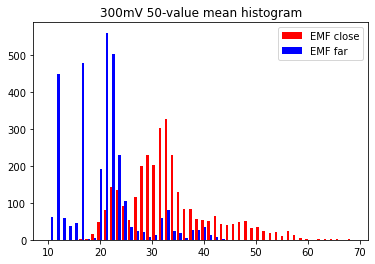

In [110]:
plt.figure()
plt.hist((close,far),bins=bins,label = ('EMF close','EMF far'),color = ('red','blue'))
plt.legend()
plt.title("%s %d-value mean histogram"%(title_prefix,mean_range))
plt.savefig("%s %d-value mean histogram"%(title_prefix,mean_range))
plt.show()

In [20]:
aut_close,quartz_close = separate(close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra)
aut_far,quartz_far = separate(far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore,start_extra = start_extra, end_extra = end_extra)

604 -41
604 -41


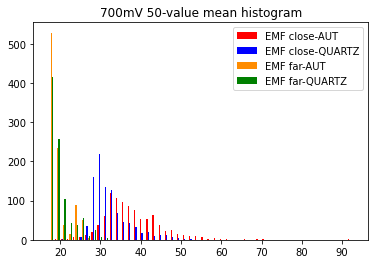

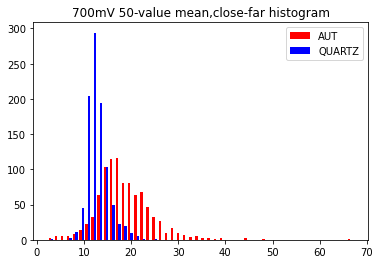

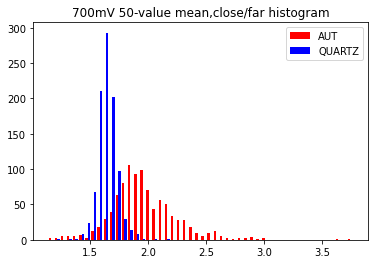

In [21]:
plt.figure()
plt.hist((aut_close,quartz_close,aut_far,quartz_far),bins=bins,label = ('EMF close-AUT','EMF close-QUARTZ','EMF far-AUT','EMF far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title("%s %d-value mean histogram"%(title_prefix,mean_range))
plt.savefig("%s %d-value mean histogram"%(title_prefix,mean_range))
plt.show()

plt.figure()
plt.hist((aut_close-aut_far,quartz_close-quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title("%s %d-value mean,close-far histogram"%(title_prefix,mean_range))
plt.savefig(fig_save_path+title_prefix + " 50-value mean,close-far histogram")
plt.show()

plt.figure()
plt.hist((aut_close/aut_far,quartz_close/quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " 50-value mean,close/far histogram")
plt.savefig(fig_save_path+title_prefix + " 50-value mean,close divide far histogram")
plt.show()

AUT: 1.967524 +- 1.805756
QUARTZ: 1.645251 +- 0.541944


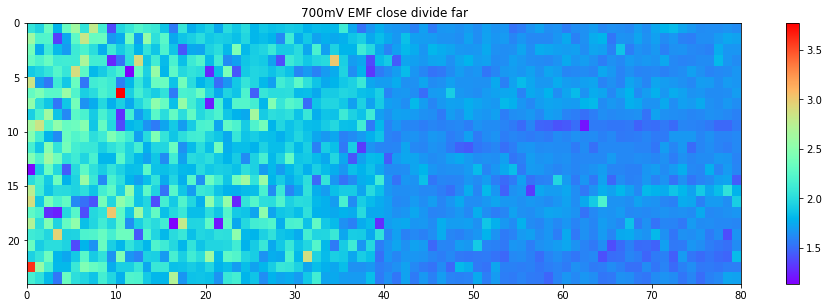

In [22]:
aut = aut_close/aut_far
quartz = quartz_close/quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(24,pqty))
quartz = np.reshape(quartz,(24,pqty))

EMF_normalized_data = np.hstack((aut,quartz))
plot_colormap(EMF_normalized_data,title = title_prefix + " EMF close divide far",path = fig_save_path)


AUT: 18.674100 +- 48.488986
QUARTZ: 12.776928 +- 12.546558


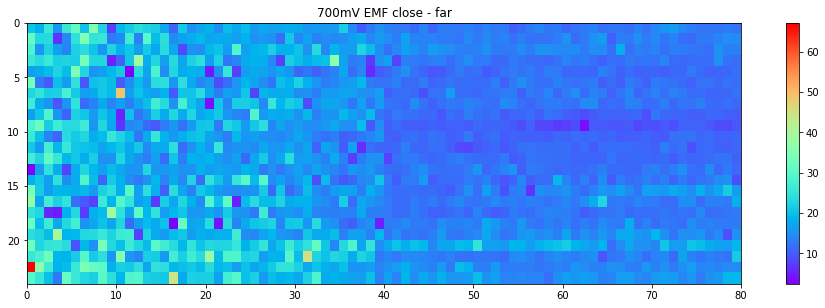

In [23]:
aut = aut_close-aut_far
quartz = quartz_close-quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(24,pqty))
quartz = np.reshape(quartz,(24,pqty))

data = np.hstack((aut,quartz))
plot_colormap(data,title = title_prefix + " EMF close - far",path = fig_save_path)

In [24]:
# Calculate on Current
abf.setSweep(0,channel=0)
X = abf.sweepX
Y = abf.sweepY
pqty = 50
mean_range=30

I_close,_,_ = calculateAvg(X,Y,stable_close,mean_range=mean_range)
I_far,_,_ = calculateAvg(X,Y,stable_far,mean_range=mean_range)
I_aut_close,I_quartz_close = separate(I_close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra)
I_aut_far,I_quartz_far = separate(I_far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra)

604 -41
604 -41


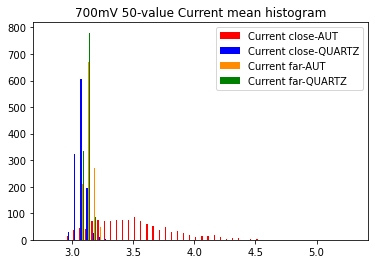

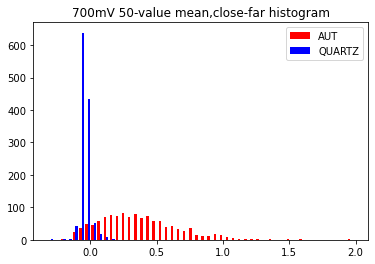

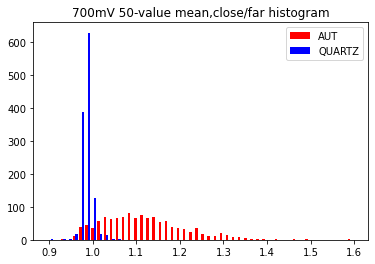

In [25]:
plt.figure()
plt.hist((I_aut_close,I_quartz_close,I_aut_far,I_quartz_far),bins=bins,label = ('Current close-AUT','Current close-QUARTZ','Current far-AUT','Current far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title(title_prefix + " 50-value Current mean histogram")
plt.savefig(fig_save_path+title_prefix + " 50-value Current mean histogram")
plt.show()

plt.figure()
plt.hist((I_aut_close-I_aut_far,I_quartz_close-I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " 50-value mean,close-far histogram")
plt.savefig(fig_save_path+title_prefix + " 50-value mean,Current close-far histogram")
plt.show()

plt.figure()
plt.hist((I_aut_close/I_aut_far,I_quartz_close/I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " 50-value mean,close/far histogram")
plt.savefig(fig_save_path+title_prefix + " 50-value mean,Current close divide far histogram")
plt.show()

In [26]:
I_aut = I_aut_close/I_aut_far
I_quartz = I_quartz_close/I_quartz_far

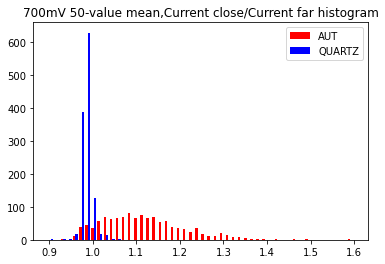

In [27]:
plt.figure()
plt.hist((I_aut,I_quartz),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " 50-value mean,Current close/Current far histogram")
plt.savefig(fig_save_path+title_prefix + " 50-value mean,Current close divide Current far histogram")
plt.show()

AUT: 1.117468 +- 0.480705
QUARTZ: 0.986320 +- 0.088619


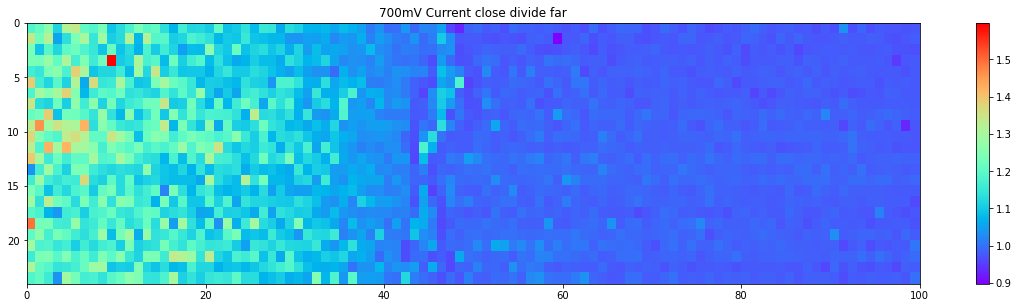

In [28]:
a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(24,pqty))
I_quartz = np.reshape(I_quartz,(24,pqty))

Current_normalized_data = np.hstack((I_aut,I_quartz))

plot_colormap(Current_normalized_data,title = title_prefix +  " Current close divide far",path = fig_save_path)

AUT: 0.369809 +- 1.614954
QUARTZ: -0.042618 +- 0.276575


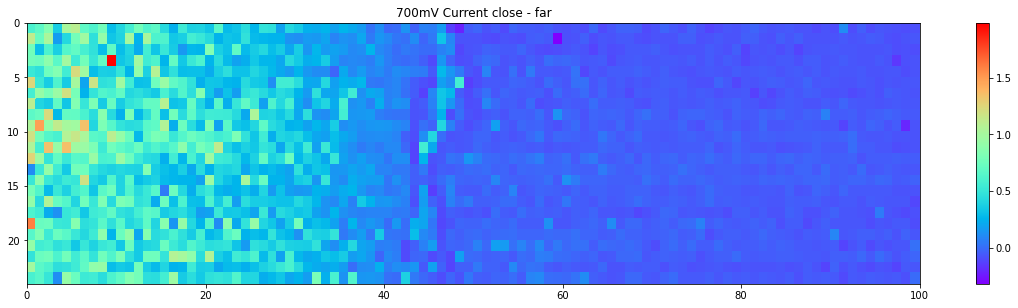

In [29]:
I_aut = I_aut_close-I_aut_far
I_quartz = I_quartz_close-I_quartz_far

a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(24,pqty))
I_quartz = np.reshape(I_quartz,(24,pqty))

data = np.hstack((I_aut,I_quartz))

plot_colormap(data,title = title_prefix +  " Current close - far",path = fig_save_path)


In [30]:
current = abf.sweepY
abf.setSweep(0,channel=2)
X = abf.sweepX
Y = abf.sweepY
log_close,log_far = logStable(X,Y,current,stable_close,stable_far,pqty)

In [31]:
# Output following information to csv file
header = ['timeStart', 'timeEnd', 'pqty', 'close','mean EMF','mean I']

with open("result\\"+abfFile+'_result.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    for log in log_close:
        data = [log.timeStart, log.timeEnd, log.pqty, log.close,log.mEMF,log.mI]
        writer.writerow(data)
        
    for log in log_far:
        data = [log.timeStart, log.timeEnd, log.pqty, log.close,log.mEMF,log.mI]
        writer.writerow(data)

In [32]:
with open("result\\"+abfFile+'_current.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in Current_normalized_data:
        writer.writerow(row)

In [33]:
with open("result\\"+abfFile+'_EMF.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in EMF_normalized_data:
        writer.writerow(row)